In [63]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# Read the pickle file
with open('../tracker_stubs/ball_detections.pkl', 'rb') as f:
    ball_positions = pickle.load(f)

In [16]:
ball_positions = [x.get(1,[]) for x in ball_positions]

df_ball_positions = pd.DataFrame(ball_positions, columns=['x1', 'y1', 'x2', 'y2'])

# Convert all values to float
df_ball_positions = df_ball_positions.apply(pd.to_numeric, errors='coerce')

# Interpolation of missing values
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()

In [18]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2'])/2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()

In [116]:
df_ball_positions['mid_y_rolling_mean']


0      425.586731
1      425.595978
2      421.459442
3      419.390488
4      414.207770
          ...    
313    718.749701
314    725.823869
315    731.138434
316    738.256299
317    745.380957
Name: mid_y_rolling_mean, Length: 318, dtype: float64

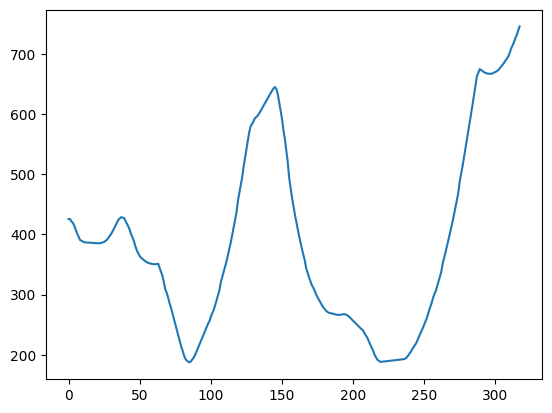

In [29]:
# Plotting the rolling mean
plt.plot(df_ball_positions['mid_y_rolling_mean'])


In [109]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()
df_ball_positions['delta_y_smooth'] = df_ball_positions['delta_y'].rolling(window=3, min_periods=1).mean()
# df_ball_positions['mid_x'] = (df_ball_positions['x1'] + df_ball_positions['x2']) / 2
# df_ball_positions['mid_x_rolling_mean'] = df_ball_positions['mid_x'].rolling(window=5, min_periods=1).mean()
# df_ball_positions['delta_x'] = df_ball_positions['mid_x_rolling_mean'].diff()
# df_ball_positions['delta_x_smooth'] = df_ball_positions['delta_x'].rolling(window=3, min_periods=1).mean()
# df_ball_positions['ball_hit'] = (
#     (df_ball_positions['delta_y_smooth'].abs() > 1.0) |
#     (df_ball_positions['delta_x_smooth'].abs() > 2.0)
# ) & (df_ball_positions['sign_change'] > 1.5)


# df_ball_positions[df_ball_positions['ball_hit'] == 1]

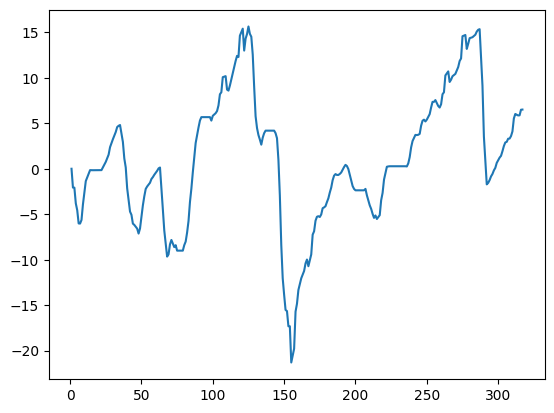

In [110]:
plt.plot(df_ball_positions['delta_y_smooth'])

In [111]:
df_ball_positions['ball_hit'] = 0

In [114]:
min_change_frames = 25

for i in range(1, len(df_ball_positions) - int(min_change_frames*1.2)):
    negative_change = df_ball_positions['delta_y_smooth'].iloc[i] > 0 and df_ball_positions['delta_y_smooth'].iloc[i+1]
    positive_change = df_ball_positions['delta_y_smooth'].iloc[i] < 0 and df_ball_positions['delta_y_smooth'].iloc[i+1]
    
    if negative_change or positive_change:
        change_count = 0
        for change_frame in range(i+1, i+int(min_change_frames*1.2)):
            negative_position_change_following_frame = df_ball_positions['delta_y_smooth'].iloc[i] >0 and df_ball_positions['delta_y_smooth'].iloc[change_frame] <0
            positive_position_change_following_frame = df_ball_positions['delta_y_smooth'].iloc[i] <0 and df_ball_positions['delta_y_smooth'].iloc[change_frame] >0
            
            if negative_change and negative_position_change_following_frame:
                change_count+=1
            elif positive_change and positive_position_change_following_frame:
                change_count+=1
    
        if change_count>min_change_frames-1:
            df_ball_positions.loc[i, 'ball_hit'] = 1

frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit']==1].index.tolist()

In [ ]:

df_ball_positions['group_id'] = (df_ball_positions['ball_hit'] != df_ball_positions['ball_hit'].shift()).cumsum()

last_hits = df_ball_positions[df_ball_positions['ball_hit'] == 1].groupby('group_id').tail(1)

df_ball_positions['ball_hit_filtered'] = 0
df_ball_positions.loc[last_hits.index, 'ball_hit_filtered'] = 1

# Implemented in BallTracker class
# net_y_position = (court_keypoints[13] + court_keypoints[15]) / 2  # y6 + y7

df_ball_positions['ball_side'] = df_ball_positions['mid_y'] > net_y_position

filtered_hits = df_ball_positions[df_ball_positions['ball_hit_filtered'] == 1]

false_hits_indices = []

for i in range(len(filtered_hits) - 1):
    current_idx = filtered_hits.index[i]
    next_idx = filtered_hits.index[i + 1]

    current_side = df_ball_positions.loc[current_idx, 'ball_side']
    next_side = df_ball_positions.loc[next_idx, 'ball_side']

    if current_side == next_side:
        false_hits_indices.append(current_idx)

df_ball_positions.loc[false_hits_indices, 'ball_hit_filtered'] = 0


df_ball_positions[df_ball_positions['ball_hit_filtered'] == 1]



,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit,sign_change,mid_x,...,delta_x,delta_x_smooth,delta_y_smooth,accel_y,accel_y_smooth,bbox_area,bbox_area_diff,ball_hits,group_id,ball_hit_filtered
39,1040.035156,410.458923,1074.287231,441.730774,426.094849,427.226724,-0.767798,1,0.0,1057.161194,...,-10.271326,-9.530350,0.153053,-0.983994,-1.256043,1071.125778,15.614831,1,2,1
86,562.317082,186.376803,577.573101,203.196359,194.786581,189.380929,1.979741,1,0.0,569.945092,...,5.248448,1.875370,-0.387443,1.783612,1.782491,256.599475,1.589146,1,4,1
146,1133.555583,613.147909,1154.463379,635.383647,624.265778,641.894445,-2.933947,1,0.0,1144.009481,...,4.019972,6.111889,0.986311,-2.378323,-1.071570,464.900281,100.184467,1,6,1
194,1012.186838,259.116110,1024.670124,272.978965,266.047538,267.517180,-0.040612,1,0.0,1018.428481,...,-1.091495,-1.297515,0.309840,-0.126987,0.134609,173.053983,0.022302,1,8,1
221,965.226115,182.413020,978.273885,196.345189,189.379105,188.811005,0.227452,1,0.0,971.750000,...,-3.931775,-3.086767,-0.478667,0.705712,0.991682,181.783747,4.816732,1,10,1
